# Importing necessary libraries

In [1]:
from google.colab import drive

In [2]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
from wordcloud import WordCloud

In [11]:
import missingno as msno
from collections import Counter
import itertools
import re
from nltk.util import ngrams
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob  # For sentiment analysis

In [12]:
import numpy as np

# Mounting google drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Defining paths

In [5]:
# Defining paths
zip_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/archive.zip"
extract_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/"

# Extracting data

In [ ]:
# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Locating the CSV file
csv_file = None
for file in os.listdir(extract_path):
    if file.endswith('.csv'):
        csv_file = os.path.join(extract_path, file)
        break

if csv_file:
    print(f"Dataset found: {csv_file}")
else:
    raise FileNotFoundError("No CSV file found in the extracted dataset.")

Dataset found: /content/drive/MyDrive/Colab Notebooks/Capstone/train.csv


# Loading the dataset

In [13]:
# This step is only necessary if you need to re-load the dataset once it has been unzipped.
csv_file = "/content/drive/MyDrive/Colab Notebooks/Capstone/train.csv"
df_nlp = pd.read_csv(csv_file)

In [14]:
# Loading dataset
df_nlp = pd.read_csv(csv_file)


# Displaying NLP Mental Health Conversations Dataset structure before cleaning

In [15]:
# Displaying dataset structure
print("\n Dataset Overview Before Cleaning:")
print(df_nlp.info())
print("\nSample Data:")
print(df_nlp.head())



 Dataset Overview Before Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB
None

Sample Data:
                                             Context  \
0  I'm going through some things with my feelings...   
1  I'm going through some things with my feelings...   
2  I'm going through some things with my feelings...   
3  I'm going through some things with my feelings...   
4  I'm going through some things with my feelings...   

                                            Response  
0  If everyone thinks you're worthless, then mayb...  
1  Hello, and thank you for your question and see...  
2  First thing I'd suggest is getting the sleep y...  
3  Therapy is essential for those that are feelin...  
4  I first want to let you know th

In [16]:
# Making a copy of the original dataset
df_nlp_copy_1 = df_nlp.copy()

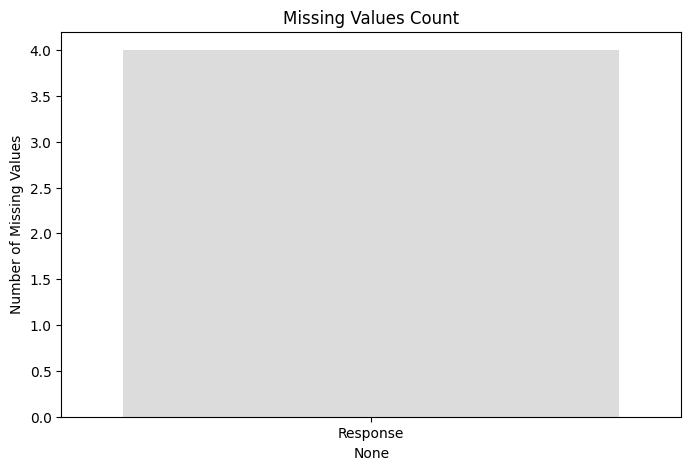

In [18]:
missing_values = df_nlp.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only showing columns with missing data
plt.figure(figsize=(8,5))
sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index, palette="coolwarm", legend=False)
plt.ylabel("Number of Missing Values")
plt.title("Missing Values Count")
plt.show()


- Since there is only "4" responses missing. We are going to proceed to fill emtpy values with: "No response provided"

In [19]:
# Downloading necessary NLTK resources
nltk.download("punkt")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
# Filling missing responses instead of dropping them
df_nlp["Response"] = df_nlp["Response"].fillna("No response provided.")



In [21]:
# Removing duplicate rows
df_nlp.drop_duplicates(inplace=True)


# Displaying NLP Mental Health Conversations Dataset structure after cleaning

In [22]:
# Displaying dataset structure after cleaning
print("\n Dataset Overview After Cleaning:")
print(df_nlp.info())
print("\nMissing Values After Cleaning:")
print(df_nlp.isnull().sum())


 Dataset Overview After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 2752 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   2752 non-null   object
 1   Response  2752 non-null   object
dtypes: object(2)
memory usage: 64.5+ KB
None

Missing Values After Cleaning:
Context     0
Response    0
dtype: int64


In [23]:
# Checking duplicates after cleaning
duplicate_count_after = df_nlp.duplicated().sum()
print("\nNumber of duplicate rows after cleaning:", duplicate_count_after)

# Confirming shape after cleaning
print("\nDataset Shape after cleaning:", df_nlp.shape)


Number of duplicate rows after cleaning: 0

Dataset Shape after cleaning: (2752, 2)


- Duplicate rows remvoed: 0.
- Final daset: (2752, 2) (Context & Response)

# Exploratory Data Analysis (NLP) for NLP Mental Health Conversations Dataset

<Figure size 1000x500 with 0 Axes>

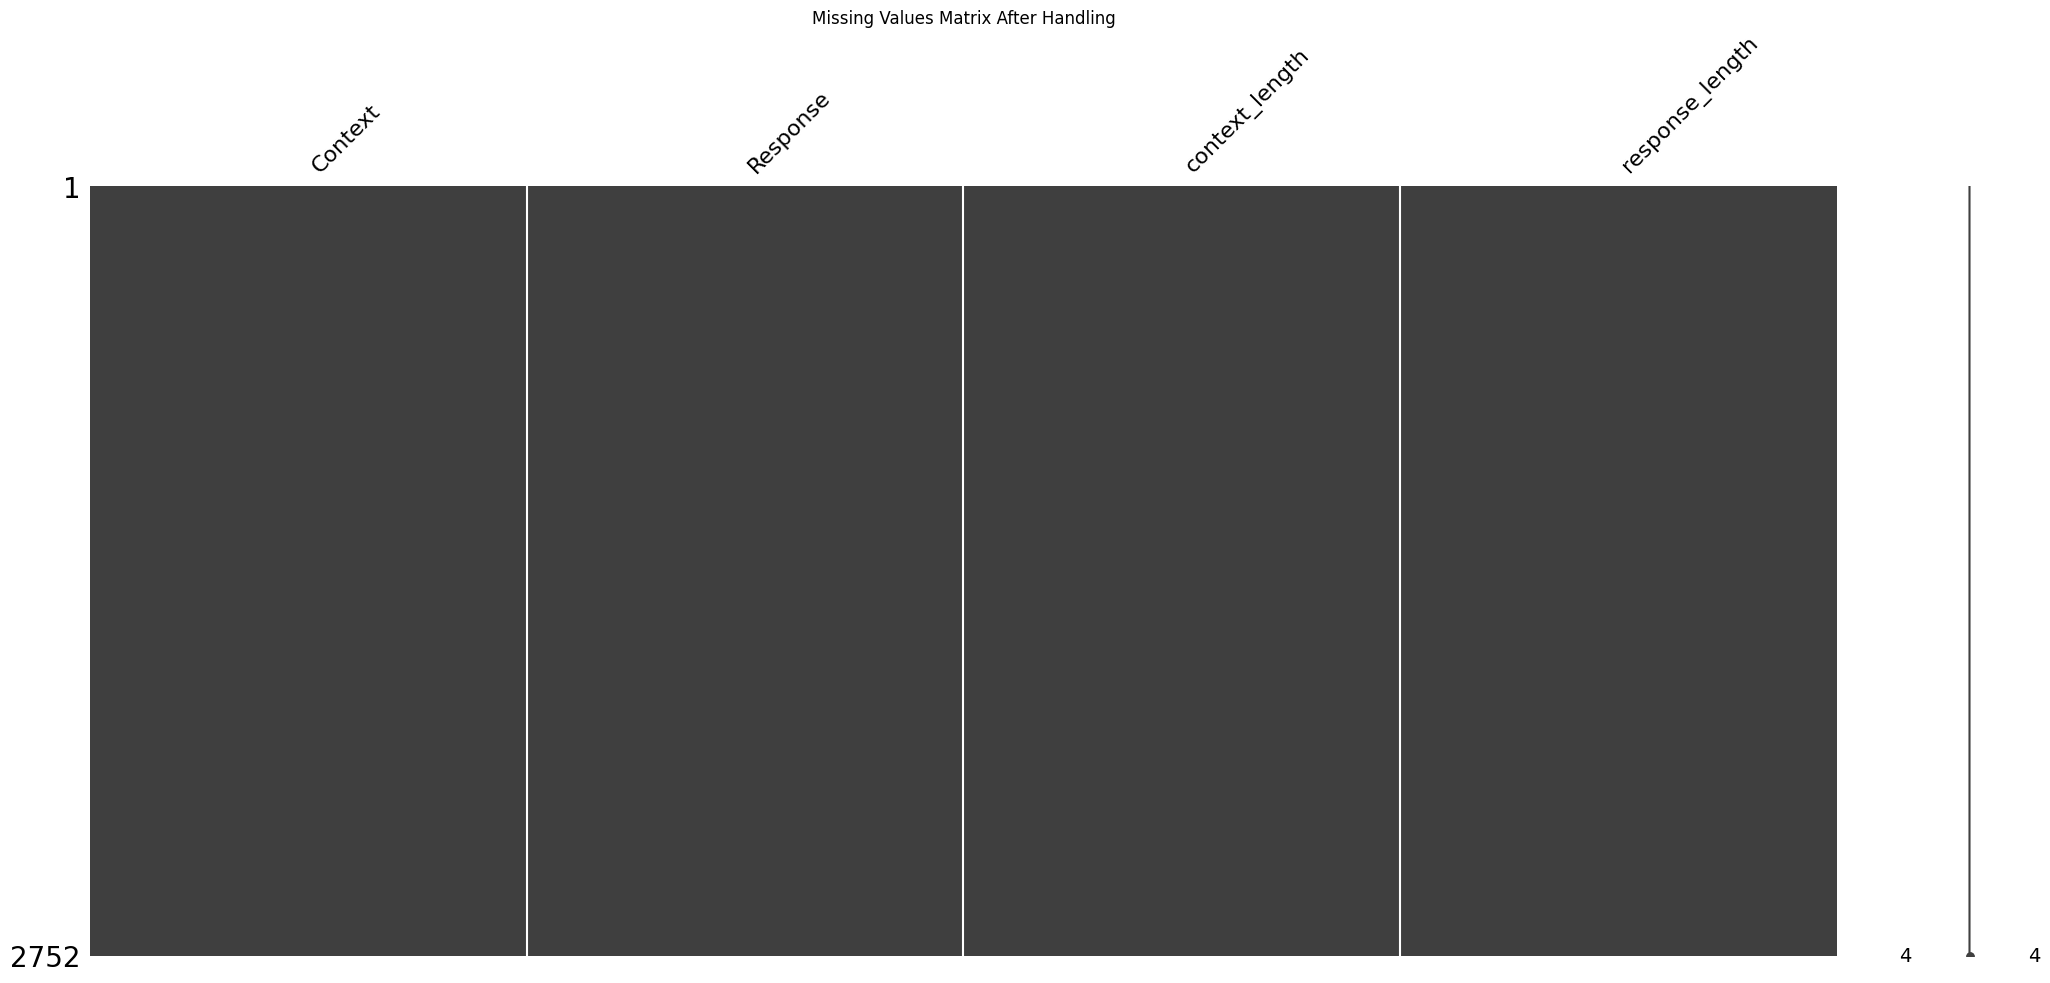

In [66]:
# Analyzing text length distribution
df_nlp['context_length'] = df_nlp['Context'].astype(str).apply(len)
df_nlp['response_length'] = df_nlp['Response'].astype(str).apply(len)

# Visualizing missing values again
plt.figure(figsize=(10,5))
msno.matrix(df_nlp)
plt.title("Missing Values Matrix After Handling")
plt.show()

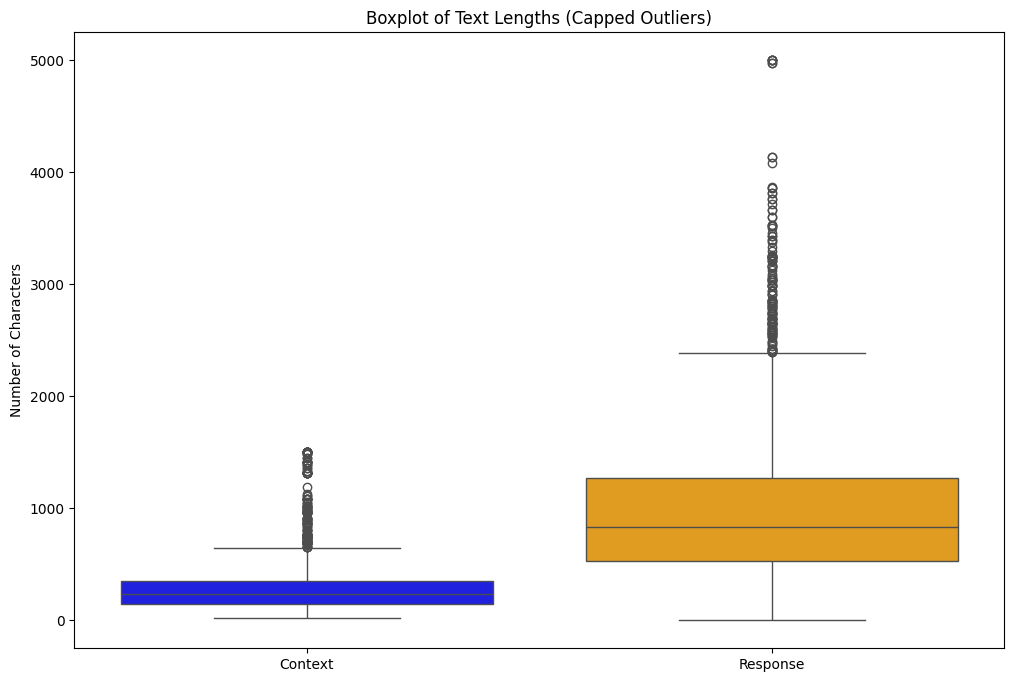

In [86]:
# Cap extreme outliers (optional: adjust threshold if needed)
df_nlp['context_length_capped'] = np.where(df_nlp['context_length'] > 1500, 1500, df_nlp['context_length'])
df_nlp['response_length_capped'] = np.where(df_nlp['response_length'] > 5000, 5000, df_nlp['response_length'])

# Create a better visualization
plt.figure(figsize=(12,8))  # Increase figure size
sns.boxplot(data=df_nlp[['context_length_capped', 'response_length_capped']], palette=["blue", "orange"])

# Update labels and title
plt.title("Boxplot of Text Lengths (Capped Outliers)")
plt.ylabel("Number of Characters")
plt.xticks([0,1], ["Context", "Response"])

# Show the plot
plt.show()

- Average context lenght: 290 characters
- Average Response lenght: 1035 characters
- Maximum response lenght: 32,739 characters. Outliers exists.

Responses tend to be much longer than the context.

There are extreme outliers in response length (Above 30,000 characters)

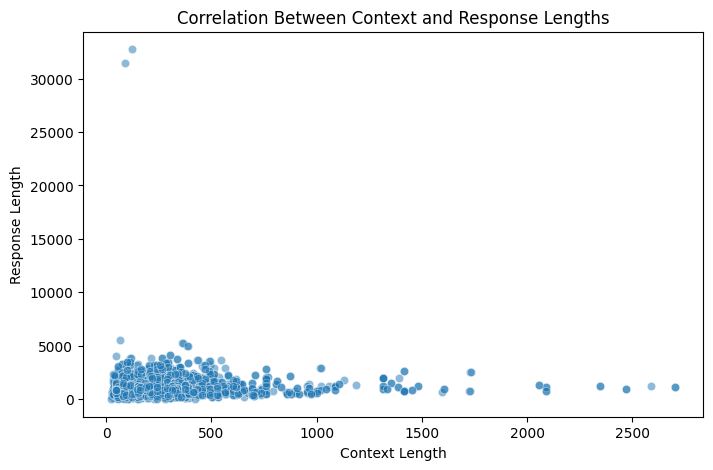


 Correlation between context length and response length: 0.043


In [68]:
# Correlation between context and response length
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_nlp["context_length"], y=df_nlp["response_length"], alpha=0.5)
plt.xlabel("Context Length")
plt.ylabel("Response Length")
plt.title("Correlation Between Context and Response Lengths")
plt.show()

correlation = np.corrcoef(df_nlp["context_length"], df_nlp["response_length"])[0, 1]
print(f"\n Correlation between context length and response length: {correlation:.3f}")

- Correlation score: 0.043

There is almost no correlations between the length of a user's input (context) and the length of the therapist's response.

This suggests that the chabot model should not assume a longer input requires  a longer response.

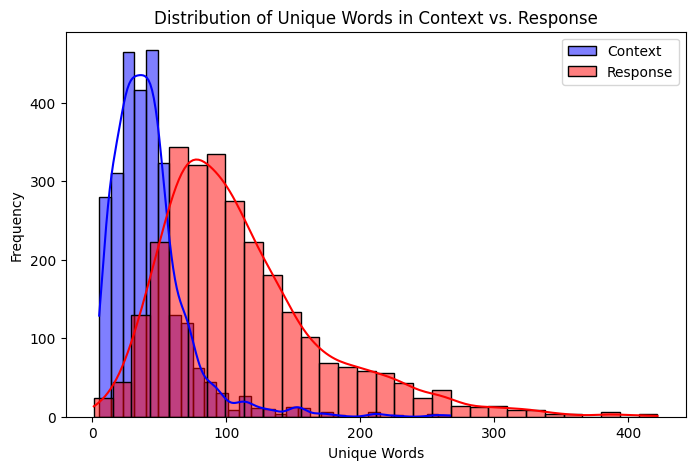

In [69]:
# Unique word count analysis
df_nlp["context_unique_words"] = df_nlp["Context"].astype(str).apply(lambda x: len(set(x.split())))
df_nlp["response_unique_words"] = df_nlp["Response"].astype(str).apply(lambda x: len(set(x.split())))

plt.figure(figsize=(8,5))
sns.histplot(df_nlp["context_unique_words"], bins=30, kde=True, label="Context", color='blue')
sns.histplot(df_nlp["response_unique_words"], bins=30, kde=True, label="Response", color='red')
plt.legend()
plt.xlabel("Unique Words")
plt.ylabel("Frequency")
plt.title("Distribution of Unique Words in Context vs. Response")
plt.show()

- Average Unique words in Context: 42 words.
- Average Unique words in Response: 112 words.

Responses contain much richer vocabulary compared to context.

The model should focus on generating diverse responses rathen than just mirroring the input.

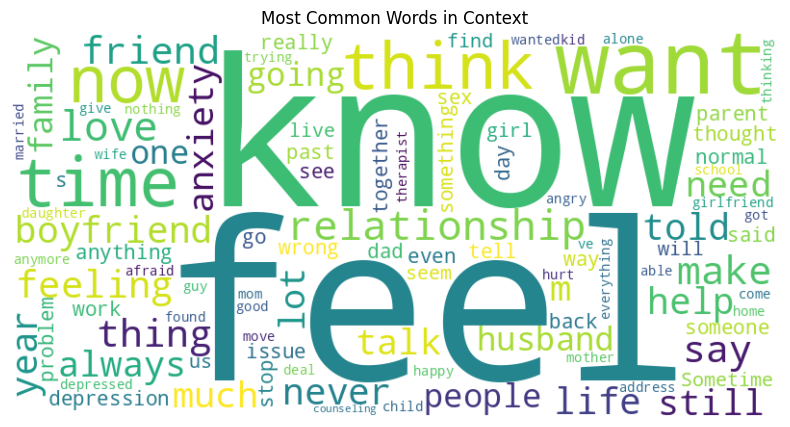

In [70]:
# Word Clouds
context_text = " ".join(df_nlp["Context"].astype(str))
response_text = " ".join(df_nlp["Response"].astype(str))

wordcloud_context = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(context_text)
wordcloud_response = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(response_text)

# Display Word Cloud for Context
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_context, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Context")
plt.show()

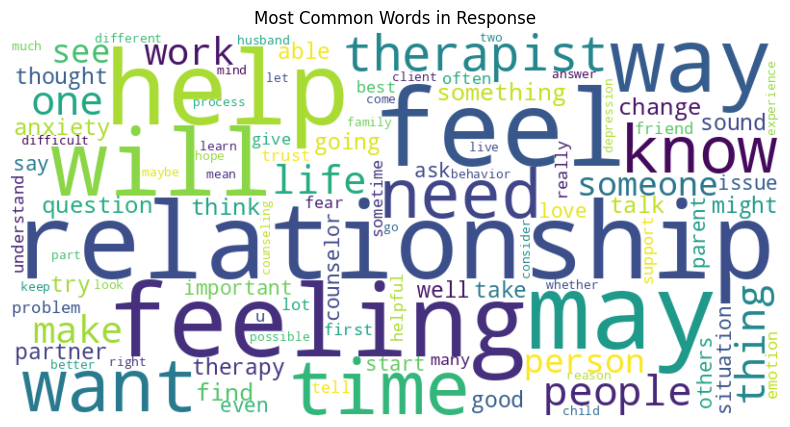

In [72]:
# Display Word Cloud for Response
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_response, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Response")
plt.show()



In [26]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [79]:
# Function to extract common bigrams and trigrams
def get_top_ngrams(text_series, n=2, top_k=10):
    """ Extracts top N-grams (bigrams/trigrams) from a pandas Series (column) """
    all_words = []

    for text in text_series.dropna():
        words = word_tokenize(str(text).lower())  # Ensure text is string
        all_words.extend(ngrams(words, n))

    return Counter(all_words).most_common(top_k)

# Extract bigrams and trigrams for Context column
common_bigrams = get_top_ngrams(df_nlp["Context"], n=2, top_k=10)
common_trigrams = get_top_ngrams(df_nlp["Context"], n=3, top_k=10)

# Display Results
print("\n Top 10 Common Bigrams in Context:")
for bigram, count in common_bigrams:
    print(f"{bigram} → {count} occurrences")

print("\n Top 10 Common Trigrams in Context:")
for trigram, count in common_trigrams:
    print(f"{trigram} → {count} occurrences")


 Top 10 Common Bigrams in Context:
('.', 'i') → 3541 occurrences
('i', "'m") → 1324 occurrences
('i', 'have') → 1278 occurrences
(',', 'and') → 1175 occurrences
('and', 'i') → 1130 occurrences
('i', 'do') → 1126 occurrences
(',', 'but') → 1060 occurrences
('do', "n't") → 884 occurrences
(',', 'i') → 762 occurrences
('.', 'he') → 745 occurrences

 Top 10 Common Trigrams in Context:
('i', 'do', "n't") → 706 occurrences
(',', 'but', 'i') → 479 occurrences
(',', 'and', 'i') → 423 occurrences
('.', 'i', 'have') → 402 occurrences
('do', "n't", 'know') → 353 occurrences
('i', '’', 'm') → 351 occurrences
('.', 'i', 'do') → 338 occurrences
('how', 'can', 'i') → 315 occurrences
('.', 'i', 'feel') → 306 occurrences
('.', 'how', 'can') → 286 occurrences


- Top 10 most common Bigrams in context:

I'm, I have, do not, but I, how can I. This suggests that users express uncertainty, concerns, and questions about their well-being.

- Top 10 most common trigramms in context:

I don't know, how can I, I feel like, but I don't. This suggests that users are often unsure or confused, seeking clarity and support.

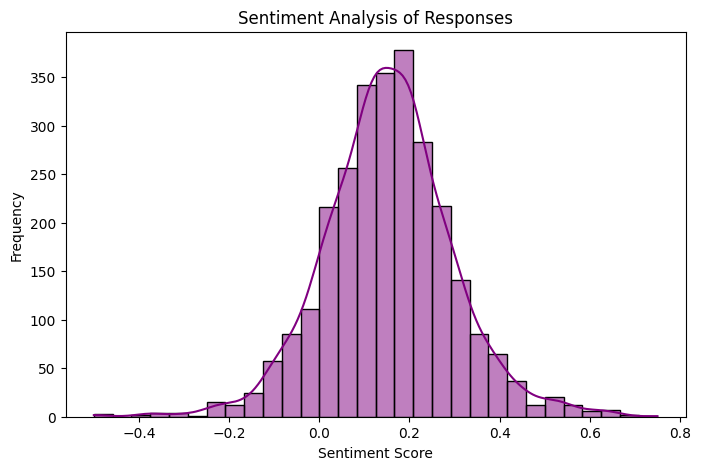


 Summary Statistics:
       context_length  response_length  context_unique_words  \
count     2752.000000      2752.000000           2752.000000   
mean       290.688227      1035.754360             42.462209   
std        260.738230      1091.735959             29.077192   
min         25.000000         1.000000              5.000000   
25%        148.750000       530.750000             24.000000   
50%        239.000000       829.500000             37.000000   
75%        349.000000      1274.250000             52.000000   
max       2703.000000     32739.000000            267.000000   

       response_unique_words  response_sentiment  
count            2752.000000         2752.000000  
mean              112.178416            0.152945  
std                62.509060            0.142404  
min                 1.000000           -0.500000  
25%                69.000000            0.067650  
50%                97.000000            0.151548  
75%               139.000000            0.23

In [80]:
# Sentiment Analysis of Responses
df_nlp["response_sentiment"] = df_nlp["Response"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting sentiment distribution
plt.figure(figsize=(8,5))
sns.histplot(df_nlp["response_sentiment"], bins=30, kde=True, color='purple')
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Analysis of Responses")
plt.show()

# Summary Statistics
print("\n Summary Statistics:")
print(df_nlp[["context_length", "response_length", "context_unique_words", "response_unique_words", "response_sentiment"]].describe())

- Mean Sentiment Score: 0.15
- Range: [-0.5, 0.75]

Majority of responses are slightly positive.

Very few strongly negative responses.


##  Sentiment Analysis Per Topic

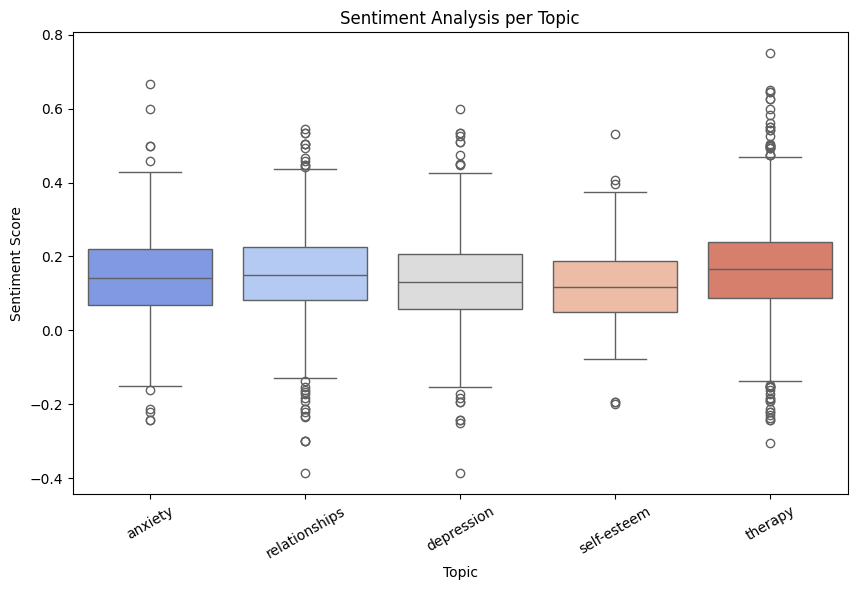

In [24]:
# Define topic keywords
topics = {
    "anxiety": ["anxiety", "stress", "panic", "worry"],
    "relationships": ["relationship", "boyfriend", "girlfriend", "husband", "wife", "partner"],
    "depression": ["depression", "sad", "hopeless", "alone"],
    "self-esteem": ["confidence", "self-esteem", "self-worth", "insecure"],
    "therapy": ["therapist", "counseling", "therapy", "session"]
}

# Function to calculate sentiment per topic
def get_topic_sentiment(df, topics):
    topic_sentiments = {topic: [] for topic in topics.keys()}

    for index, row in df.iterrows():
        response_text = str(row["Response"]).lower()
        sentiment_score = TextBlob(response_text).sentiment.polarity

        for topic, keywords in topics.items():
            if any(keyword in response_text for keyword in keywords):
                topic_sentiments[topic].append(sentiment_score)

    return topic_sentiments

# Run the function on the dataset
topic_sentiments = get_topic_sentiment(df_nlp, topics)

# Convert results to a DataFrame
topic_sentiment_df = pd.DataFrame(
    {topic: pd.Series(scores) for topic, scores in topic_sentiments.items()}
)

# Plot Sentiment Distribution for Topics
plt.figure(figsize=(10,6))
sns.boxplot(data=topic_sentiment_df, palette="coolwarm")
plt.title("Sentiment Analysis per Topic")
plt.xlabel("Topic")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=30)
plt.show()


- Most topics show a positive sentiment skew, meaning responses generally have a reassuring, supportive, or constructive tone.

Topic Comparisons:

- Anxiety & Relationships: Show a higher median sentiment score, indicating these discussions often contain more comforting or helpful responses.

- Depression & Self-Esteem: Have a slightly lower median sentiment, with a few negative sentiment outliers (possibly indicating responses reflecting deep struggles or serious concerns).

- Therapy: Has the widest sentiment distribution, meaning some responses might be highly positive (encouraging therapy), while others might be neutral or negative (e.g., skepticism or concerns about therapy).

Outliers:

The presence of negative sentiment outliers across all topics suggests that some responses express distress, frustration, or skepticism.

We should examine these outliers to understand if they stem from personal struggles, misinformation, or therapy skepticism.

## POS Tagging & Named Entity Recognition (NER)

In [28]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [29]:
import spacy
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

# Function to get POS tags from text
def get_pos_tags(text):
    words = word_tokenize(text)
    return pos_tag(words)

# Function to get named entities from text
def get_named_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply functions to the dataset
df_nlp["POS_Tags"] = df_nlp["Response"].apply(get_pos_tags)
df_nlp["Named_Entities"] = df_nlp["Response"].apply(get_named_entities)

# Display most common named entities
all_named_entities = sum(df_nlp["Named_Entities"].tolist(), [])
common_entities = Counter(all_named_entities).most_common(10)

print("\n Most Common Named Entities in Responses:")
for entity, count in common_entities:
    print(f"{entity} → {count} occurrences")



 Most Common Named Entities in Responses:
('first', 'ORDINAL') → 522 occurrences
('one', 'CARDINAL') → 334 occurrences
('two', 'CARDINAL') → 307 occurrences
('One', 'CARDINAL') → 209 occurrences
('First', 'ORDINAL') → 166 occurrences
('un', 'ORG') → 110 occurrences
('DBH', 'ORG') → 71 occurrences
('NCC', 'ORG') → 66 occurrences
('3', 'CARDINAL') → 59 occurrences
('Robin J. Landwehr', 'PERSON') → 56 occurrences


- ORDINAL: Words like "first", "One", "First". These indicate ordering (e.g., first step, first thing to do).

- CARDINAL: Numbers such as "one", "two", "3". These are likely used to describe steps or ranking.

- ORG (Organizations):

  - UN (United Nations?)
  - DBH (Department of Behavioral Health?)
  - NCC (Possibly referring to a mental health or counseling organization).

- PERSON:

"Robin J. Landwehr": This could be a reference to an expert, author, or therapist mentioned in responses.